# COCO Dataset Generator
> forked from [here](https://www.kaggle.com/coldfir3/efficient-coco-dataset-generator)

In [1]:
!pip install -Uqqq pycocotools

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from pathlib import Path
from pycocotools.coco import COCO
from PIL import Image

# Params

In [3]:
FOLD = 0
dataDir=Path('../input/sartorius-cell-instance-segmentation/train')

# Meta Data

In [4]:
df = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
df.head()

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   
3     520    shsy5y  11h30m00s  2019-06-16   
4     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

# Data Split

In [5]:
df = df.reset_index(drop=True)
df['fold'] = -1
skf = GroupKFold(n_splits=5)
for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df['cell_type'], groups=df['id'])):
    df.loc[val_idx, 'fold'] = fold

# Helper

In [6]:
## Based on: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
def rle2mask(rle, img_w, img_h):
    
    ## transforming the string into an array of shape (2, N)
    array = np.fromiter(rle.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1
    
    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction
    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img = np.asfortranarray(msk_img) ## This is important so pycocotools can handle this object
    
    return msk_img

## Minor Sanity Check

118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4


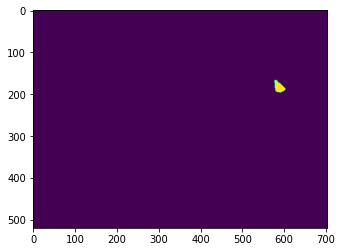

In [7]:
rle = df.loc[0, 'annotation']
print(rle)
plt.imshow(rle2mask(rle, 704, 520));

# COCO Annotations

In [8]:
from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed
import json,itertools

def annotate(idx, row, cat_ids):
        mask = rle2mask(row['annotation'], row['width'], row['height']) # Binary mask
        c_rle = maskUtils.encode(mask) # Encoding it back to rle (coco format)
        c_rle['counts'] = c_rle['counts'].decode('utf-8') # converting from binary to utf-8
        area = maskUtils.area(c_rle).item() # calculating the area
        bbox = maskUtils.toBbox(c_rle).astype(int).tolist() # calculating the bboxes
        annotation = {
            'segmentation': c_rle,
            'bbox': bbox,
            'area': area,
            'image_id':row['id'], 
            'category_id':1, # cat_ids[row['cell_type']], 
            'iscrowd':0, 
            'id':idx
        }
        return annotation
    
def coco_structure(df, workers = 4):
    
    ## Building the header
    cat_ids = {"cell":1}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'{id}.png'}\
              for id,row in df.groupby('id').agg('first').iterrows()]
    
    ## Building the annotations
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

In [9]:
train_df = df.query("fold!=@FOLD")
valid_df = df.query("fold==@FOLD")

In [10]:
train_json = coco_structure(train_df)
valid_json = coco_structure(valid_df)

  0%|          | 0/58869 [00:00<?, ?it/s]

  0%|          | 0/14716 [00:00<?, ?it/s]

In [11]:
display(train_json['annotations'][0])
display(valid_json['annotations'][0])

{'segmentation': {'size': [520, 704],
  'counts': 'Ymb07o?1O2N1O1O1O2N100O10O010O010O0010O001O001O1N2O1O001O1O1O100O10O2O001O001N1O2N1O2O010O00010O01O01O01O01O00001O00001O00001O00001O00001O0O101O001O001O1O001O001O1O2N1OjPY9'},
 'bbox': [37, 46, 82, 90],
 'area': 1282,
 'image_id': '0140b3c8f445',
 'category_id': 1,
 'iscrowd': 0,
 'id': 395}

{'segmentation': {'size': [520, 704],
  'counts': 'WeT97Q`0<D6J2N1O01O101N1O1O0010O01O1O1N2O1N2O1N2O1N2O1N2N2M_Sc1'},
 'bbox': [576, 167, 27, 30],
 'area': 498,
 'image_id': '0030fd0e6378',
 'category_id': 1,
 'iscrowd': 0,
 'id': 0}

In [12]:
with open('annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(train_json, f, ensure_ascii=True, indent=4)
with open('annotations_valid.json', 'w', encoding='utf-8') as f:
    json.dump(valid_json, f, ensure_ascii=True, indent=4)

# COCO Image

In [13]:
!mkdir -p train2017
!mkdir -p valid2017

In [14]:
import shutil
def run_copy(row):
    img_path = dataDir/f'{row.id}.png'
    if row.fold!=FOLD:
        shutil.copy(img_path, './train2017/')
    else:
        shutil.copy(img_path, './valid2017/')

In [15]:
tmp_df = df.groupby('id').agg('first').reset_index()
_ = Parallel(n_jobs=-1,
         backend='threading')(delayed(run_copy)(row) for _, row in tqdm(tmp_df.iterrows(),
                                                                        total=len(tmp_df)))

  0%|          | 0/606 [00:00<?, ?it/s]

# Sanity check

In [16]:
# annFile = Path('./annotations_train.json')
# coco = COCO(annFile)
# imgIds = coco.getImgIds()

# imgs = coco.loadImgs(imgIds[-3:])
# _,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
# for img, ax in zip(imgs, axs):
#     I = Image.open(dataDir/img['file_name'])
#     annIds = coco.getAnnIds(imgIds=[img['id']])
#     anns = coco.loadAnns(annIds)
#     ax[0].imshow(I)
#     ax[1].imshow(I)
#     plt.sca(ax[1])
#     coco.showAnns(anns, draw_bbox=True)
# plt.tight_layout()
# plt.show()

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


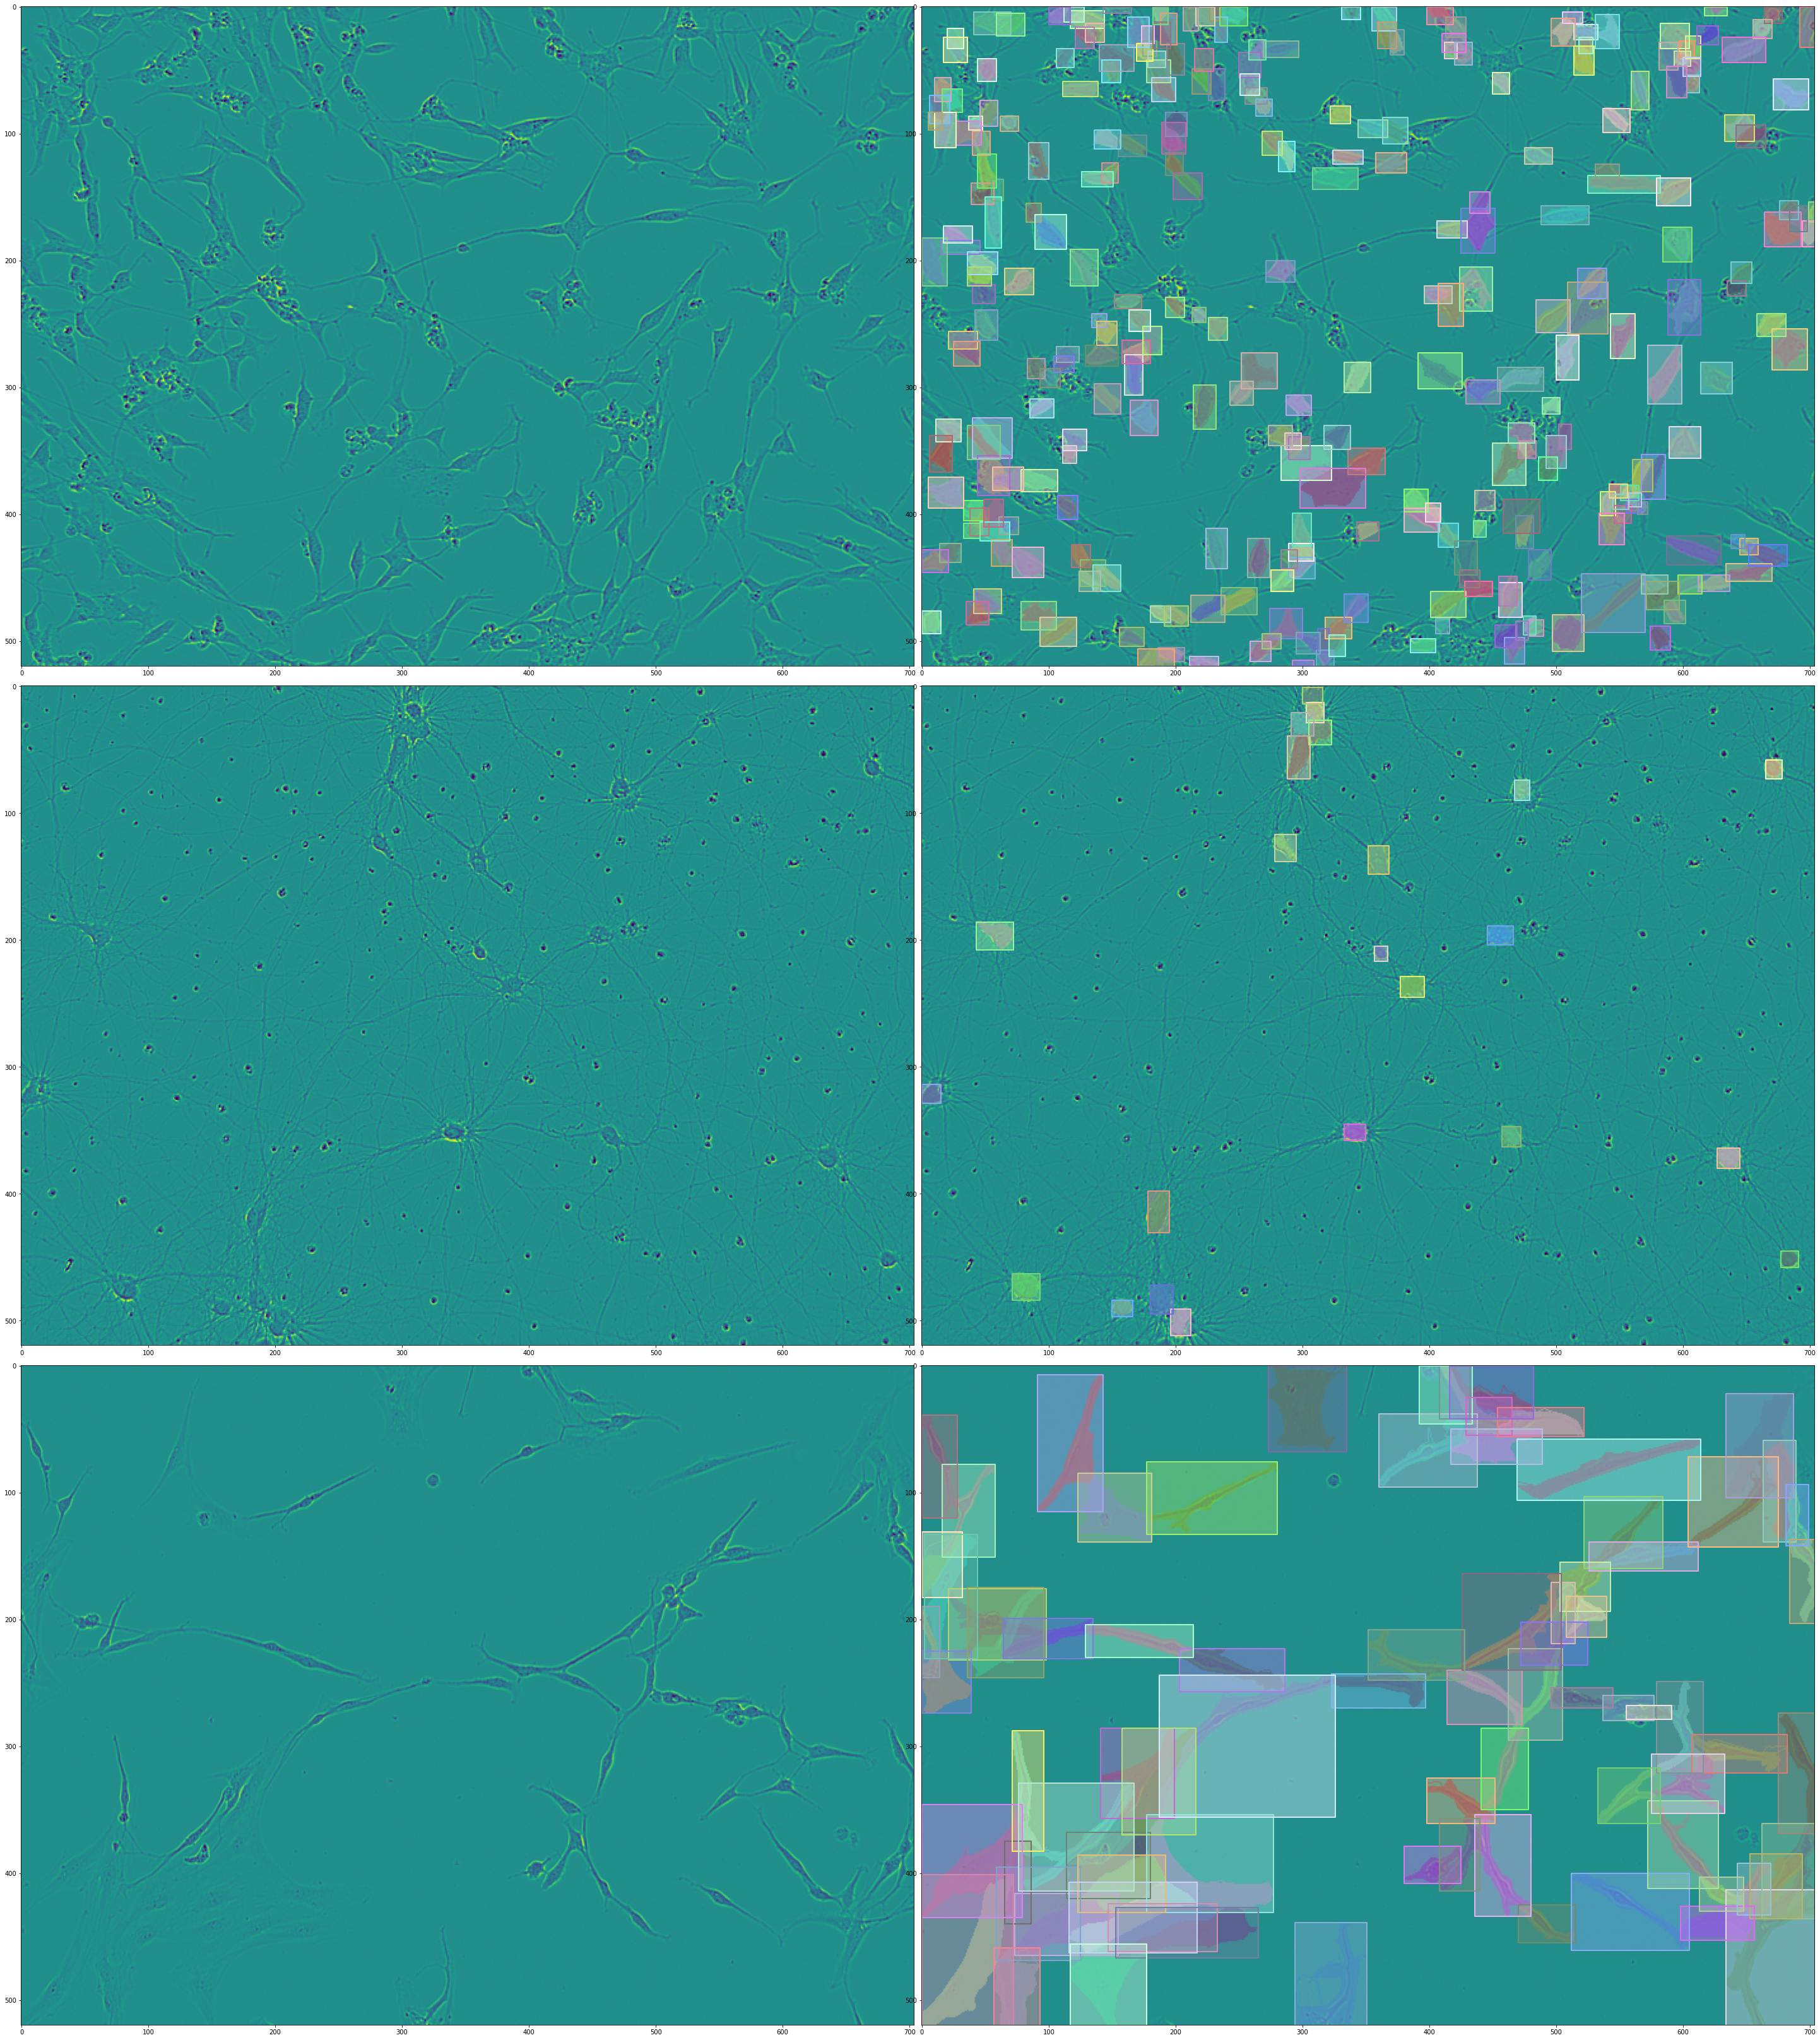

In [17]:
annFile = Path('./annotations_valid.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()

imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)
plt.tight_layout()
plt.show()

# Compress files

In [18]:
shutil.make_archive('valid2017', 'zip', 'valid2017')
shutil.make_archive('train2017', 'zip', 'train2017')

'/kaggle/working/train2017.zip'

In [19]:
!rm -r train2017
!rm -r valid2017